In [1]:
# python libraries
import pandas as pd
import numpy as np
from math import log

import re

import matplotlib.pyplot as plt
import seaborn as sns

# load R into python
% load_ext rpy2.ipython
# show plots inline
% matplotlib inline

In [2]:
# set figure aesthetics

cat_colours = sns.xkcd_palette(["cerulean", "goldenrod", "red", "grass green"])

chain_colours = sns.color_palette()

sns.set_context(rc={"lines.linewidth":1.2})

sns.set(font_scale=1.3)

In [3]:
%%R 
# R libraries
library("lme4")
library("lmerTest")

In [4]:
# function to make printing from R output faster

def print_output(output):
    
    for line in output:
        
        print line

In [5]:
# read in data files 
ex1 = pd.read_csv("../data_files/ex1.csv")
ex2 = pd.read_csv("../data_files/ex2.csv")
ex3 = pd.read_csv("../data_files/ex3.csv")

## Contents

1. <a href='#funcs'>Functions for efficiency measures</a>
2. <a href='#gest-len'>Gesture sequence length</a>
    * <a href='#gl-ex1'>Experiment 1</a>
    * <a href='#gl-ex2'>Experiment 2</a>
    * <a href='#gl-ex3'>Experiment 3</a>
3. <a href='#reps'>Frequency of repetitions</a>
    * <a href='#r-ex1'>Experiment 1</a>
    * <a href='#r-ex2'>Experiment 2</a>
    * <a href='#r-ex3'>Experiment 3</a>

## 1. Functions for efficiency measures

<a id='funcs'></a>

In [6]:
# get length of gesture code

# split gesture into list of elements

# count number of elements

def code_length(df):
    
    # for each row in df
    for row in range(len(df)):
        
        # get code string
        code = df.loc[row, "code_string"]
        
        # if there is no value, data missing
        if pd.isnull(code):
            
            df.loc[row, 'code_len'] = np.nan
        
        else:
            
            # split code into list elements
            elements = code.split(',')
            
            # count elements
            code_len = len(elements)
            
            df.loc[row, 'code_len'] = code_len
            

In [7]:
#takes a list of gesture coding, and pulls out the shapes, giving a list of all instances of all shapes
# and a set of the shapes used

def shape_list(alist,reg):
    
    """
    
    Takes a list of gesture coding and gives a list of each shape,
    and the set of unique shapes.
    
    Takes as input a list of code and the regular expression that identifies gesture shapes.
    
    """
    
    #join list of code
    allcode=(',').join(alist)
    
    #search for gesture shapes (expressions starting with 1h or 2h)
    regex=re.compile(reg)
    setlist=re.findall(regex,allcode)
    
    #return the list of shapes and the set of different shapes
    return setlist, set(setlist)

In [8]:
def remove_rep_tag(df):
    
    '''
    Remove gesture internal repetitions from code
    
    '''
    
    for row in range(len(df)):
        
        code = df.loc[row, 'code_string']
        
        if pd.isnull(code) == False:
        
            new_code = re.sub('repeat\[|\]', '', code)
        
            df.loc[row, 'code_string'] = new_code

In [9]:

def count_repeats(code):
    
    ''' 
    
    Count the number of repetitions in a gesture sequence
    
    '''
    
    code_list, code_set = shape_list([code], r'1h.*?\b|2h.*?\b')
    
    num_reps = len(code_list) - len(code_set)
    
    return num_reps

In [10]:
def count_repeats_df(df):
    
    '''
    Count number of repetitions for each row in a data frame.
    
    '''
    
    for row in range(len(df)):
        
        code_str = df.loc[row, "code_string"]
        
        if pd.isnull(code_str) == False:
            
            df.loc[row, "num_reps"] = count_repeats(code_str)
            
            

## 2. Gesture sequence length

<a id='gest-len'></a>

In [11]:
# add code length column
code_length(ex1)
code_length(ex2)
code_length(ex3)

In [12]:
ex1.to_csv("../data_files/ex1.csv", index=False)
ex2.to_csv("../data_files/ex2.csv", index=False)
ex3.to_csv("../data_files/ex3.csv", index=False)

### Experiment 1

<a id='gl-ex1'></a>

Plot showing mean gesture sequence length across generations in experiment 1.

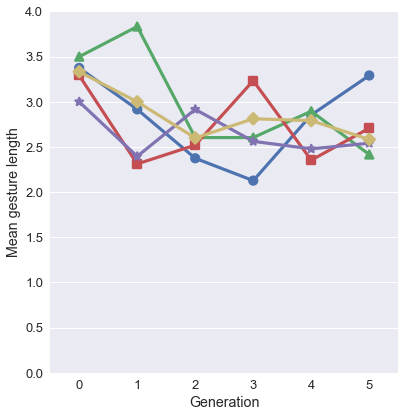

In [13]:
code_len_ex1_plot = sns.factorplot(x='generation', y='code_len', hue='chain',
                                  ci=None, data=ex1,
                                 size = 6, aspect = 1, legend=False,
                                     markers=['o','^','s', '*', 'D'],)

code_len_ex1_plot.set(xlabel= "Generation", ylabel = "Mean gesture length", xticklabels = [0,1,2,3,4,5],
                     ylim=(0,4))


The models below analyse the effect of generation on the length of gesture sequences. Firstly, we run a generalised mixed effects model with a poisson distribution (for count data). 

**Outcome variable:**
 * gesture sequence length
 
**Fixed effects:**
 * generation
 
**Random effects:**
 * chain (random intercept, random slope of generation)
 * participant (random intercept, nested in chains)
 * target meaning

In [14]:
%R -i ex1

In [15]:
%%R

# run glm poisson models

len_model_ex1 = glmer(code_len ~ generation +
                            (1+ generation|chain) + (1|participant:chain)+
                            (1|target), data=ex1, family='poisson',
                             control=glmerControl(optimizer='bobyqa'))


In [16]:
len_model_ex1 = %R capture.output(summary(len_model_ex1))

print_output(len_model_ex1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
code_len ~ generation + (1 + generation | chain) + (1 | participant:chain) +  
    (1 | target)
   Data: ex1
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  4496.4   4532.7  -2241.2   4482.4     1308 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3821 -0.5188 -0.1197  0.3523  4.5855 

Random effects:
 Groups            Name        Variance  Std.Dev. Corr 
 participant:chain (Intercept) 0.0073737 0.08587       
 target            (Intercept) 0.0277700 0.16664       
 chain             (Intercept) 0.0041834 0.06468       
                   generation  0.0002604 0.01614  -1.00
Number of obs: 1315, groups:  participant:chain, 170; target, 24; chain, 5

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.08878    0.05785  18.820   <2e-16 ***
generation  -0.03183    0.01

The model demonstrates a significant effect of generation on gesture sequence length. Here, gesture sequences become shorter over generations.

In [18]:
%R ex1_from0 = subset(ex1, generation!=0);

In [19]:
%%R

# model without seed generation

len_model_ex1_from0 = glmer(code_len ~ generation +
                            (1+ generation|chain) + (1|participant:chain)+
                            (1|target), data=ex1_from0, family='poisson',
                             control=glmerControl(optimizer='bobyqa'))


In [20]:
len_model_ex1_from0 = %R capture.output(summary(len_model_ex1_from0))

print_output(len_model_ex1_from0)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
code_len ~ generation + (1 + generation | chain) + (1 | participant:chain) +  
    (1 | target)
   Data: ex1_from0
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  4052.0   4087.6  -2019.0   4038.0     1188 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4222 -0.5031 -0.1289  0.3150  4.7640 

Random effects:
 Groups            Name        Variance Std.Dev. Corr 
 participant:chain (Intercept) 0.006392 0.07995       
 target            (Intercept) 0.028679 0.16935       
 chain             (Intercept) 0.015844 0.12587       
                   generation  0.001166 0.03415  -1.00
Number of obs: 1195, groups:  participant:chain, 50; target, 24; chain, 5

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.007909   0.082197  12.262   <2e-16 ***
generation  -0.009851   0.

### Experiment 2

<a id='gl-ex2'></a>

Plot showing the mean length of gesture sequences over generations/rounds for each chain/pair in each condition of experiment 2.

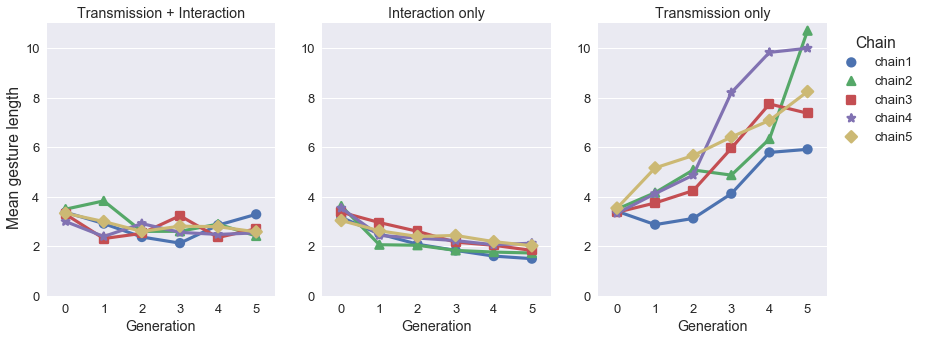

In [38]:
code_len_ex2_plot = sns.factorplot(x='generation', y='code_len', hue='chain',
                                  ci=None, data=ex2, col='condition',
                                 size = 5, aspect = 0.8, legend=False,
                                     markers=['o','^','s', '*', 'D'],
                                      sharey=False,
                                     col_order = ["Transmission + Interaction",
                                                 "Interaction only", "Transmission only"])

code_len_ex2_plot.set(xlabel= "Generation", ylabel = "", xticklabels = [0,1,2,3,4,5],
                     ylim=(0,11))

code_len_ex2_plot.set_titles('{col_name}')

plt.legend(title='Chain', bbox_to_anchor=(1,1))

plt.text(-16, 8, 'Mean gesture length', rotation=90)

The models below analyse the effect of generation and condition on the length of gesture sequences. Firstly, we run a generalised mixed effects model with a poisson distribution (for count data). 

**Outcome variable:**
 * gesture sequence length
 
**Fixed effects:**
 * generation
 * condition
 * generation * condition
 
**Random effects:**
 * chain (random intercept, random slope of generation)
 * participant (random intercept, nested in chains)
 * target meaning

In [18]:
%R -i ex2

In [19]:
%%R


# set transmission + interaction as baseline condition
ex2$condition = relevel(ex2$condition, "Transmission + Interaction")


# run poisson models
len_model_ex2 = glmer(code_len ~ generation * condition +
                            (1+generation|chain) + (1|participant:chain)+
                            (1|target), data=ex2, family='poisson',
                             control=glmerControl(optimizer='bobyqa'))

In [20]:
len_model_ex2 = %R capture.output(summary(len_model_ex2))

print_output(len_model_ex2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: code_len ~ generation * condition + (1 + generation | chain) +  
    (1 | participant:chain) + (1 | target)
   Data: ex2
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 11598.3  11665.6  -5788.1  11576.3     3343 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8934 -0.4885 -0.0976  0.3672  5.0464 

Random effects:
 Groups            Name        Variance  Std.Dev. Corr
 participant:chain (Intercept) 0.0207016 0.14388      
 target            (Intercept) 0.0376253 0.19397      
 chain             (Intercept) 0.0001934 0.01391      
                   generation  0.0001218 0.01104  1.00
Number of obs: 3354, groups:  participant:chain, 282; target, 24; chain, 5

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                            1.095283 

The model here shows a significant effect of generation for the baseline condition (ex1), and significant interactions between generation and the two other conditions. Gestures in the interaction-only condition show a further reduction in length, while gestures in the transmission-only condition show an increase in length.

### Experiment 3

<a id='gl-ex3'></a>

Plot showing the mean length of gesture sequences over generations/rounds for each chain/pair in each condition of experiment 3.

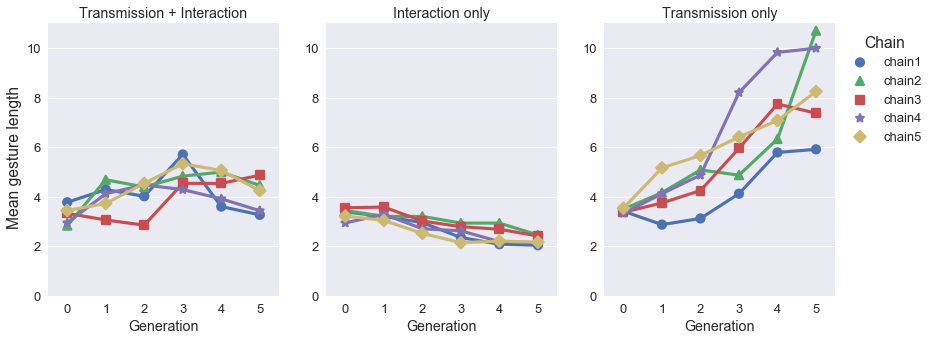

In [37]:
code_len_ex3_plot = sns.factorplot(x='generation', y='code_len', hue='chain',
                                  ci=None, data=ex3, col='condition',
                                 size = 5, aspect = 0.8, legend=False,
                                     markers=['o','^','s', '*', 'D'],
                                      sharey=False,
                                     col_order = ["Transmission + Interaction",
                                                 "Interaction only", "Transmission only"])

code_len_ex3_plot.set(xlabel= "Generation", ylabel = "", xticklabels=[0,1,2,3,4,5],
                     ylim=(0,11))

code_len_ex3_plot.set_titles('{col_name}')

plt.legend(title='Chain', bbox_to_anchor=(1,1))

plt.text(-16, 8, 'Mean gesture length', rotation=90)

The models below analyse the effect of generation and condition on the length of gesture sequences. Firstly, we run a generalised mixed effects model with a poisson distribution (for count data). 

The model structure here is the same as experiment 2.

**Outcome variable:**
 * gesture sequence length
 
**Fixed effects:**
 * generation
 * condition
 * generation * condition
 
**Random effects:**
 * chain (random intercept, random slope of generation)
 * participant (random intercept, nested in chains)
 * target meaning

In [22]:
%R -i ex3

In [23]:
%%R

# set transmission + interaction condition as baseline condition
ex3$condition = relevel(ex3$condition, 'Transmission + Interaction')

In [24]:
%%R

# run glm mixed effects models with poisson distribution

len_model_ex3 = glmer(code_len ~ generation * condition +
                            (1+generation|chain) + (1|participant)+
                            (1|target), data=ex3, family='poisson',
                             control=glmerControl(optimizer='bobyqa'))



In [25]:
len_model_ex3 = %R capture.output(summary(len_model_ex3))

print_output(len_model_ex3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: code_len ~ generation * condition + (1 + generation | chain) +  
    (1 | participant) + (1 | target)
   Data: ex3
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 12495.2  12562.3  -6236.6  12473.2     3286 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0649 -0.5087 -0.0693  0.3919  7.7565 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr
 participant (Intercept) 0.0379654 0.19485      
 target      (Intercept) 0.0393856 0.19846      
 chain       (Intercept) 0.0000000 0.00000      
             generation  0.0003342 0.01828   NaN
Number of obs: 3297, groups:  participant, 132; target, 24; chain, 5

Fixed effects:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                            1.24853    0.06344  19.680  < 2e-16 ***
generation  

## 2. Frequency of repetitions

<a id='reps'></a>

In [27]:
for ex in [ex1, ex2, ex3]:
    
    remove_rep_tag(ex)
    count_repeats_df(ex)


### Experiment 1

<a id='r-ex1'></a>

Plot showing frequency of repetitions over generations for each chain in experiment 1.

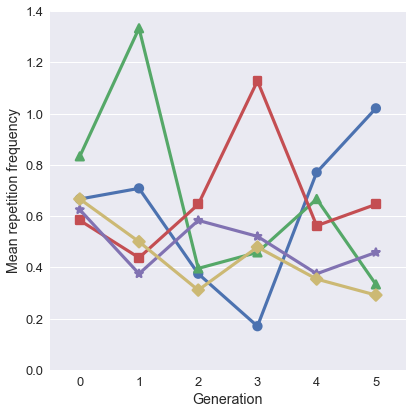

In [28]:
reps_ex1_plot = sns.factorplot(x='generation', y='num_reps', hue='chain',
                                  ci=None, data=ex1,
                                 size = 6, aspect = 1, legend=False,
                                     markers=['o','^','s', '*', 'D'],
                                     )

reps_ex1_plot.set(xlabel= "Generation", ylabel = "Mean repetition frequency", xticklabels = [0,1,2,3,4,5],
                 ylim=(0,1.4))

In [29]:
%R -i ex1

In [30]:
%%R

# run poisson models

reps_model_ex1 = glmer(num_reps ~ generation +
                            (1+ generation|chain) + (1|participant:chain)+
                            (1|target), data=ex1, family='poisson',
                             control=glmerControl(optimizer='bobyqa'))


In [31]:
reps_ex1 = %R capture.output(summary(reps_model_ex1))

print_output(reps_ex1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
num_reps ~ generation + (1 + generation | chain) + (1 | participant:chain) +  
    (1 | target)
   Data: ex1
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  2536.6   2572.9  -1261.3   2522.6     1308 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5252 -0.6607 -0.4591  0.4900  6.1396 

Random effects:
 Groups            Name        Variance Std.Dev. Corr 
 participant:chain (Intercept) 0.153624 0.39195       
 target            (Intercept) 0.327573 0.57234       
 chain             (Intercept) 0.008106 0.09003       
                   generation  0.003878 0.06228  -0.80
Number of obs: 1315, groups:  participant:chain, 170; target, 24; chain, 5

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.66167    0.15794  -4.189  2.8e-05 ***
generation  -0.05169    0.04348  

### Experiment 2

<a id='r-ex2'></a>

Plots showing the frequency of repetitions for each generation/round in each chain/pair across conditions in experiment 2.

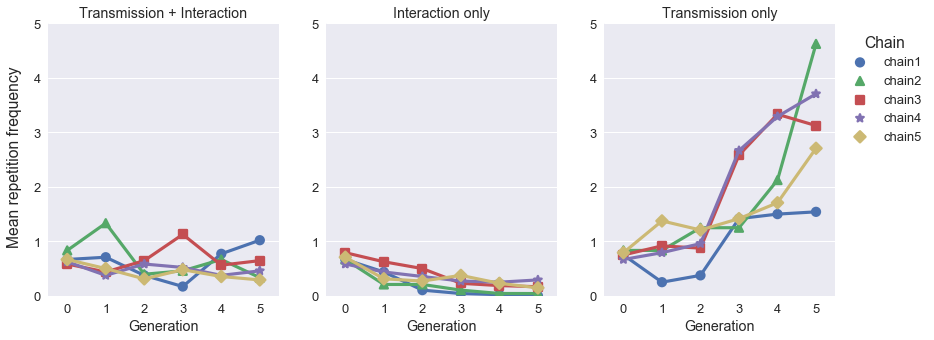

In [35]:
reps_ex2_plot = sns.factorplot(x='generation', y='num_reps', hue='chain',
                                  ci=None, data=ex2, col='condition',
                                 size = 5, aspect = 0.8, legend=False,
                                     markers=['o','^','s', '*', 'D'],
                                      sharey=False,
                                     col_order = ["Transmission + Interaction",
                                                 "Interaction only", "Transmission only"])

reps_ex2_plot.set(xlabel= "Generation", ylabel = "", xticklabels = [0,1,2,3,4,5],
                 ylim=(0,5))

reps_ex2_plot.set_titles('{col_name}')

plt.legend(title='Chain', bbox_to_anchor=(1,1))

plt.text(-16, 4, 'Mean repetition frequency', rotation=90)

The models below analyse the effect of generation and condition on repetition frequency. We run a generalised mixed effects model with a poisson distribution (for count data). 

**Outcome variable:**
 * frequency of repetitions
 
**Fixed effects:**
 * generation
 * condition
 * generation * condition
 
**Random effects:**
 * chain (random intercept, random slope of generation)
 * participant (random intercept, nested in chains)
 * target meaning

In [32]:
%R -i ex2

In [33]:
%%R 

# set transmission + interaction as baseline condition

ex2$condition = relevel(ex2$condition, 'Transmission + Interaction')

In [34]:
%%R

# run glmer with poisson distribution for count data

reps_model_ex2 = glmer(num_reps ~ generation * condition +
                            (1+generation|chain) + (1|participant:chain)+
                            (1|target), data=ex2, family = 'poisson',
                               control=glmerControl(optimizer='bobyqa'))



In [35]:
reps_model_ex2 = %R capture.output(summary(reps_model_ex2))

print_output(reps_model_ex2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_reps ~ generation * condition + (1 + generation | chain) +  
    (1 | participant:chain) + (1 | target)
   Data: ex2
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  6267.8   6335.1  -3122.9   6245.8     3343 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0708 -0.6205 -0.3857  0.3876  6.8155 

Random effects:
 Groups            Name        Variance  Std.Dev. Corr 
 participant:chain (Intercept) 0.1964859 0.44327       
 target            (Intercept) 0.2015427 0.44894       
 chain             (Intercept) 0.0007529 0.02744       
                   generation  0.0015149 0.03892  -0.36
Number of obs: 3354, groups:  participant:chain, 282; target, 24; chain, 5

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           -0.62

We find no main effect of generation for the baseline condition, but we do find significant interactions with both other conditions. Gestures in the interaction-only condition show reduction in the number of repetitions over generations, compared to the baseline. Gestures in the transmission-only condition show an increase in repetitions over generations, relative to the baseline condition.

### Experiment 3

<a id='r-ex3'></a>

Plots showing the frequency of repetitions for each generation/round in each chain/pair across conditions in experiment 3.

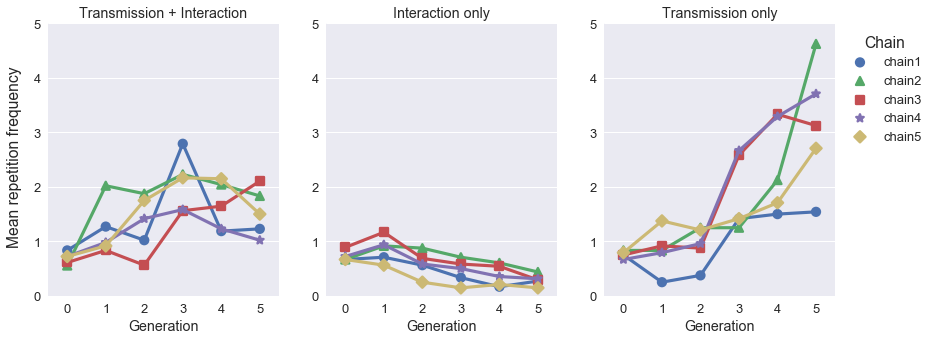

In [36]:
reps_ex3_plot = sns.factorplot(x='generation', y='num_reps', hue='chain',
                                  ci=None, data=ex3, col='condition',
                                 size = 5, aspect = 0.8, legend=False,
                                     markers=['o','^','s', '*', 'D'],
                                      sharey=False,
                                     col_order = ["Transmission + Interaction",
                                                 "Interaction only", "Transmission only"])

reps_ex3_plot.set(xlabel= "Generation", ylabel = "", xticklabels = [0,1,2,3,4,5],
                 ylim=(0,5))

reps_ex3_plot.set_titles('{col_name}')

axs = reps_ex3_plot.axes

plt.legend(title='Chain', bbox_to_anchor=(1,1))

plt.text(-16, 4, 'Mean repetition frequency', rotation=90)

The models below analyse the effect of generation and condition on repetition frequency. We run a generalised mixed effects model with a poisson distribution (for count data). 

The model structure here is the same as experiment 2.

**Outcome variable:**
 * frequency of repetitions
 
**Fixed effects:**
 * generation
 * condition
 * generation * condition
 
**Random effects:**
 * chain (random intercept, random slope of generation)
 * participant (random intercept, nested in chains)
 * target meaning

In [37]:
%R -i ex3

In [38]:
%%R 

# set transmission + interaction as baseline condition

ex3$condition = relevel(ex3$condition, 'Transmission + Interaction')

In [39]:
%%R

# run glmer with poisson distribution

reps_model_ex3 = glmer(num_reps ~ generation * condition +
                            (1+generation|chain) + (1|participant:chain)+
                            (1|target), data=ex3, family='poisson',
                             control=glmerControl(optimizer='bobyqa'))


In [40]:
reps_model_ex3 = %R capture.output(summary(reps_model_ex3))

print_output(reps_model_ex3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_reps ~ generation * condition + (1 + generation | chain) +  
    (1 | participant:chain) + (1 | target)
   Data: ex3
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  8410.5   8477.6  -4194.2   8388.5     3286 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1683 -0.7141 -0.3000  0.5297 12.5347 

Random effects:
 Groups            Name        Variance  Std.Dev. Corr
 participant:chain (Intercept) 0.1366525 0.36967      
 target            (Intercept) 0.1007781 0.31746      
 chain             (Intercept) 0.0003035 0.01742      
                   generation  0.0008281 0.02878  1.00
Number of obs: 3297, groups:  participant:chain, 264; target, 24; chain, 5

Fixed effects:
                                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           -0.22519   

The model here demonstrates an effect of generation for the baseline condition: repetitions increase over generations. We also find significant interactions between generation and condition for both other conditions. In the interaction-only condition, gestures reduce over generations compared with the baseline. In the transmission-only condition, they increase.